## Final Project Submission

Please fill out:
* Student name: Matthew Sparr
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli 
* Blog post URL:

## Introduction

For this project I chose a Kaggle dataset for an ongoing competition that can be found at https://www.kaggle.com/c/petfinder-adoption-prediction. This competition involves predicting the speed of adoption for a pet adoption site in Malaysia. Provided are various data fields such as the color of the pet, the age, and the breed. 

Also provided are image data on uploaded photos of the pets that was ran through Google's Vision API and sentiment data that was ran through Google's Natural Language API, on the description given for the pets. 

![title](petfinder.png)

## Import libraries

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os
import json
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

## Grab train and test set

The test set provided does not include the 'AdoptionSpeed' target variable and is only used to make predictions to submit to Kaggle for scoring.

In [12]:
train = pd.read_csv('train/train.csv')
test = pd.read_csv('test/test.csv')

## Fill missing values

The 'Name' and 'Description' columns are the only two columns will missing data for both the train and test set. Since both fields are text, they will be filled with a blank space, ' '.

In [4]:
train.isna().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [5]:
test.isna().sum()

Type              0
Name            303
Age               0
Breed1            0
Breed2            0
Gender            0
Color1            0
Color2            0
Color3            0
MaturitySize      0
FurLength         0
Vaccinated        0
Dewormed          0
Sterilized        0
Health            0
Quantity          0
Fee               0
State             0
RescuerID         0
VideoAmt          0
Description       2
PetID             0
PhotoAmt          0
dtype: int64

In [6]:
train.Name.fillna(' ', inplace=True)
train.Description.fillna(' ', inplace=True)

test.Name.fillna(' ', inplace=True)
test.Description.fillna(' ', inplace=True)

## Explore variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022794D508D0>,
      dtype=object)

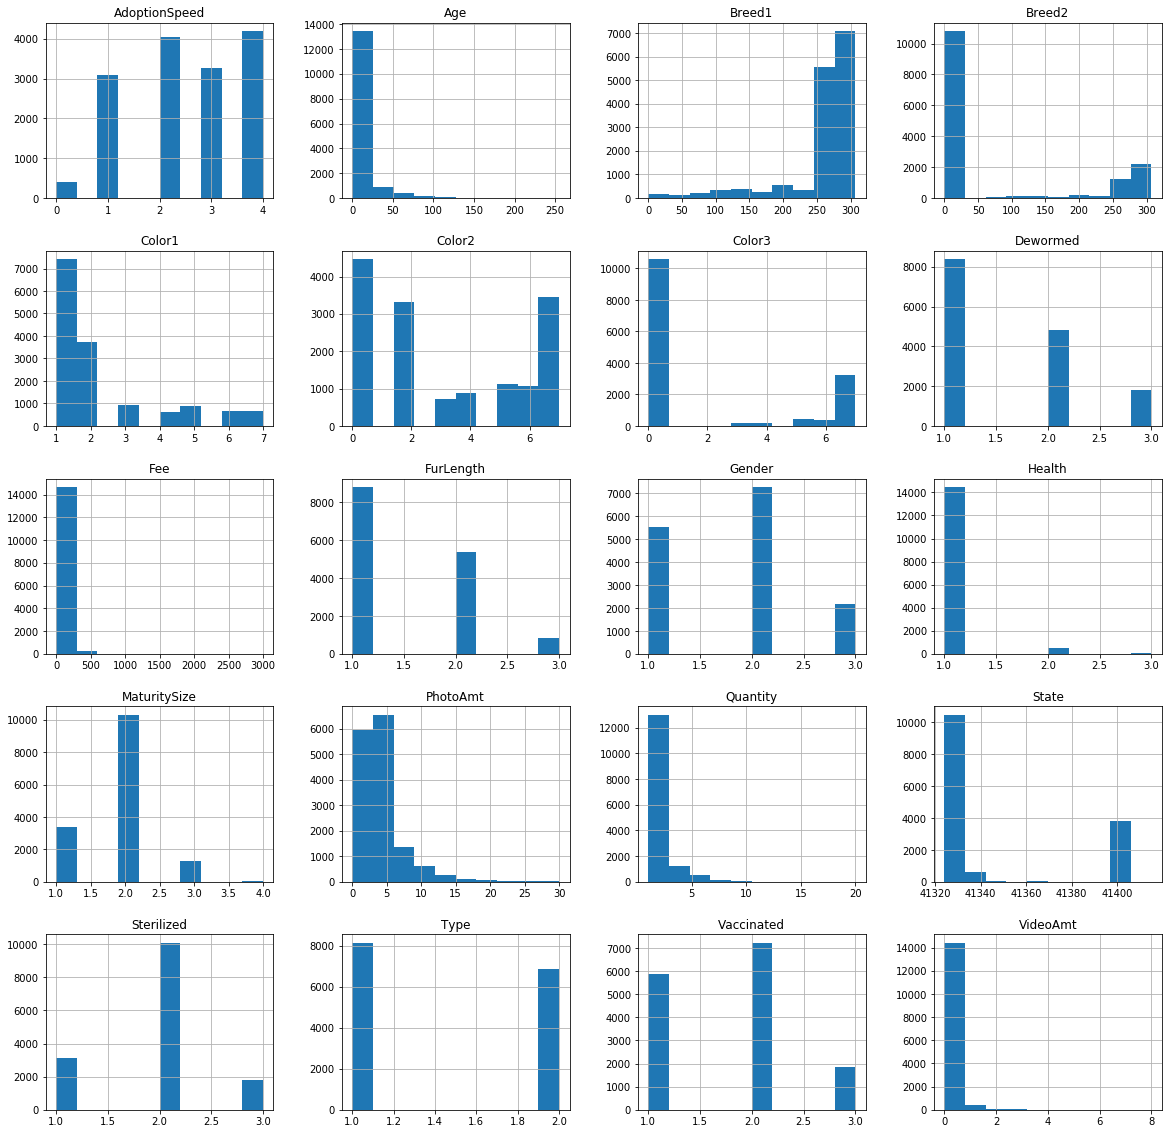

In [219]:
train.hist(figsize=(20,20))

<b>Most of the variables do not have a normal distribution which means we will probably want to standardize them later on. The target variable 'AdoptionSpeed' has a low count of '0' values which could negatively impact training a classifier on the training set.

We can also see that most pets have only one breed and one color as there are many zero values for 'Breed2', 'Color2', and 'Color3'.

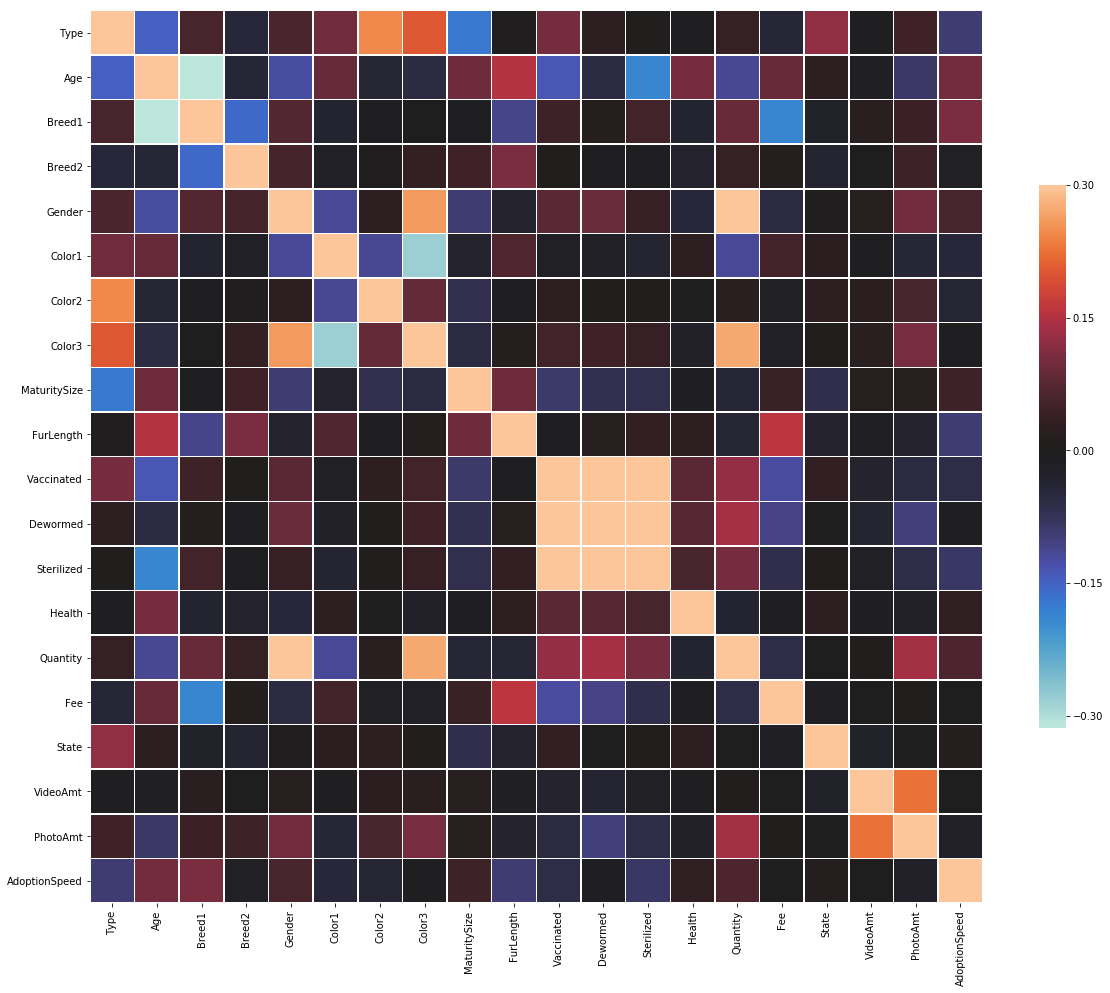

In [8]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5,cbar_kws={"shrink": .5})

<b>From the correlation graph above we can see that the only significant correlations are between the 'Vaccinate', 'Dewormed', and 'Sterilized' variables. This is most likely due to the fact that if a pet has been taken to a vet, it is likely that all three of these treatments will be given and not just one or two of them.

We can look at the correlation coefficients below to see that 'Vaccinated' and 'Dewormed' have the highest at 0.722. This is somewhat high but not high enough to have to consider removing or combining the columns.

In [9]:
train.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()[0:10]

AdoptionSpeed  AdoptionSpeed    1.000000
Vaccinated     Dewormed         0.722596
Gender         Quantity         0.494489
Vaccinated     Sterilized       0.471204
Dewormed       Sterilized       0.426256
Breed1         Age              0.314346
Color1         Color3           0.282897
Quantity       Color3           0.272548
Color3         Gender           0.259309
Type           Color2           0.246333
dtype: float64

<b>Now we can look at some of the value counts of various columns just to get a feel of the distribution of the pets.

## Are dogs or cats more common?

Text(0.5, 1.0, 'Type Distribution')

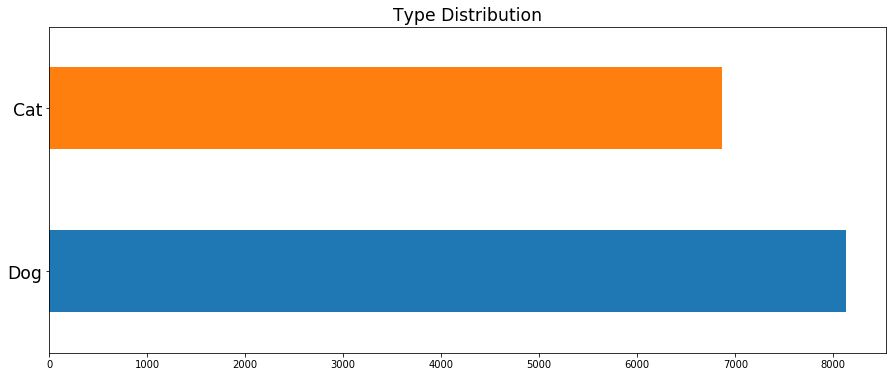

In [31]:
train['Type'].value_counts().rename({1:'Dog',
                                        2:'Cat'}).plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.title('Type Distribution', fontsize='xx-large')

<b>Slightly more dogs than cats.

## Do dogs and cats have different adoption rates on average?

Text(0.5, 1.0, 'Adoption Speed Distribution (Dogs)')

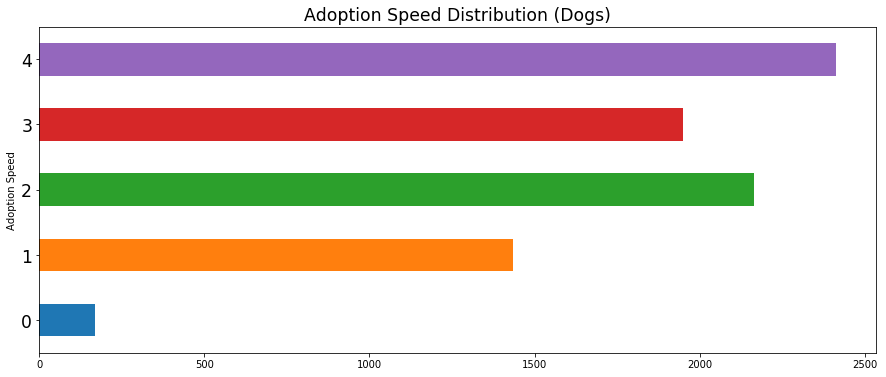

In [54]:
train['AdoptionSpeed'][train['Type'] == 1].value_counts().sort_index().plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.ylabel('Adoption Speed')
plt.title('Adoption Speed Distribution (Dogs)', fontsize='xx-large')

Text(0.5, 1.0, 'Adoption Speed Distribution (Cats)')

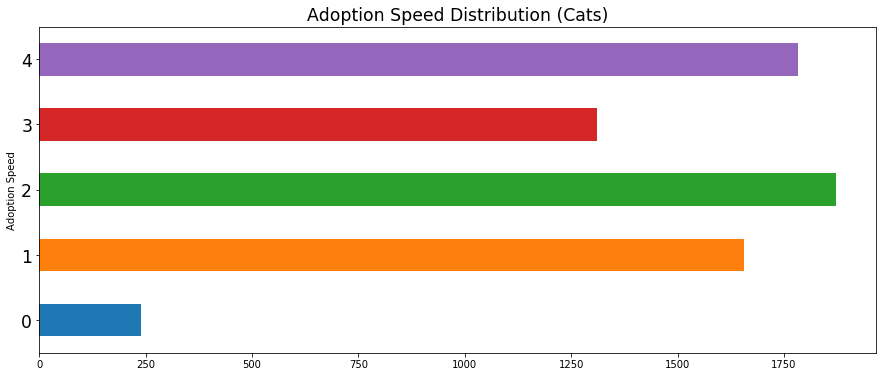

In [53]:
train['AdoptionSpeed'][train['Type'] == 2].value_counts().sort_index().plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.ylabel('Adoption Speed')
plt.title('Adoption Speed Distribution (Cats)', fontsize='xx-large')

Text(0.5, 1.0, 'Average Adoption Speed')

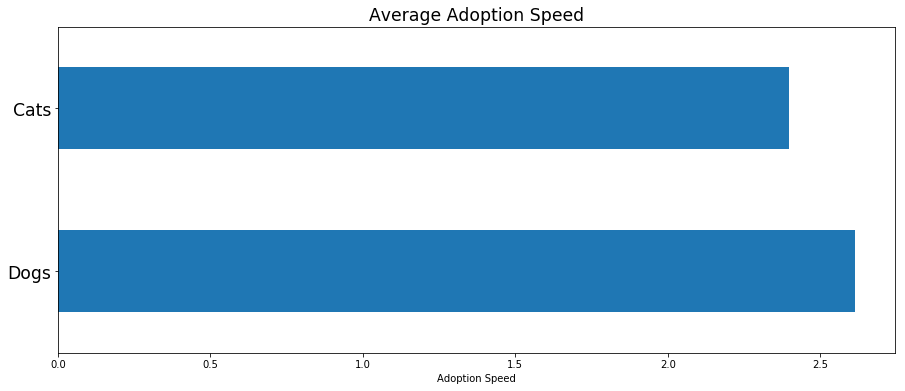

In [57]:
pd.DataFrame([train['AdoptionSpeed'][train['Type'] == 1].mean(),train['AdoptionSpeed'][train['Type'] == 2].mean()]).rename({0:'Dogs',
                                        1:'Cats'}).plot(kind='barh',
                                                       figsize=(15,6), legend=None)
plt.yticks(fontsize='xx-large')
plt.xlabel('Adoption Speed')
plt.title('Average Adoption Speed', fontsize='xx-large')

<b> The largest number of dogs aren't adopted after 100 days of being listed whereas the largest number of cats are adopted in the first month of being listed. Dogs on average take a longer amount of time to be adopted than cats.

## What breeds are most common?

Text(0.5, 1.0, 'Breed Distribution (Breed1)')

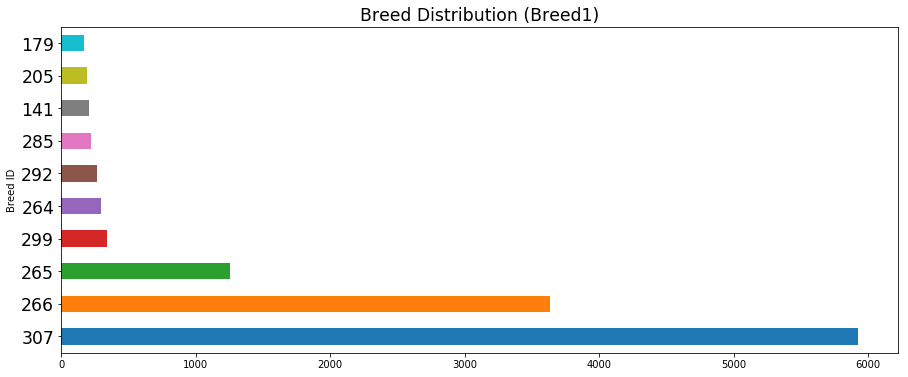

In [36]:
train['Breed1'].value_counts().head(10).plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.ylabel('Breed ID')
plt.title('Breed Distribution (Breed1)', fontsize='xx-large')

<b> Breed 307 which signifies an unknown breed is the most common primary breed followed by Breed 266 which are domestic shorthair cats.

Text(0.5, 1.0, 'Breed Distribution(Breed2)')

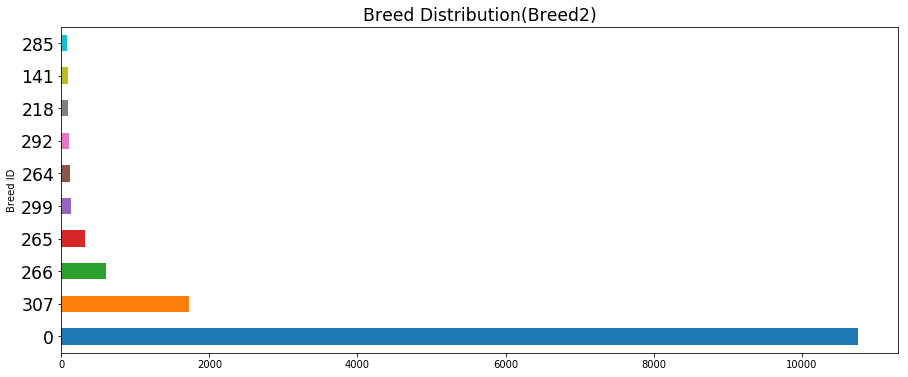

In [37]:
train['Breed2'].value_counts().head(10).plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.ylabel('Breed ID')
plt.title('Breed Distribution(Breed2)', fontsize='xx-large')

<b> Most pets do not have a second breed but the largest number of the ones that do have an unknown second breed.

## More male or female pets?

Text(0.5, 1.0, 'Gender Distribution (excluding groups of pets)')

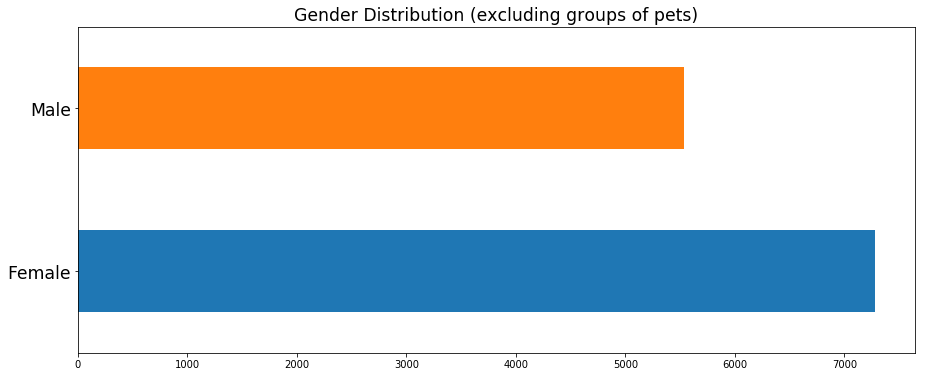

In [66]:
train['Gender'][(train['Gender'] == 1) | (train['Gender'] == 2)].value_counts().rename({1:'Male',
                                        2:'Female'}).plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.title('Gender Distribution (excluding groups of pets)', fontsize='xx-large')

<b> More pets are female.

## 

Text(0.5, 1.0, 'Amount of Photos Distribution')

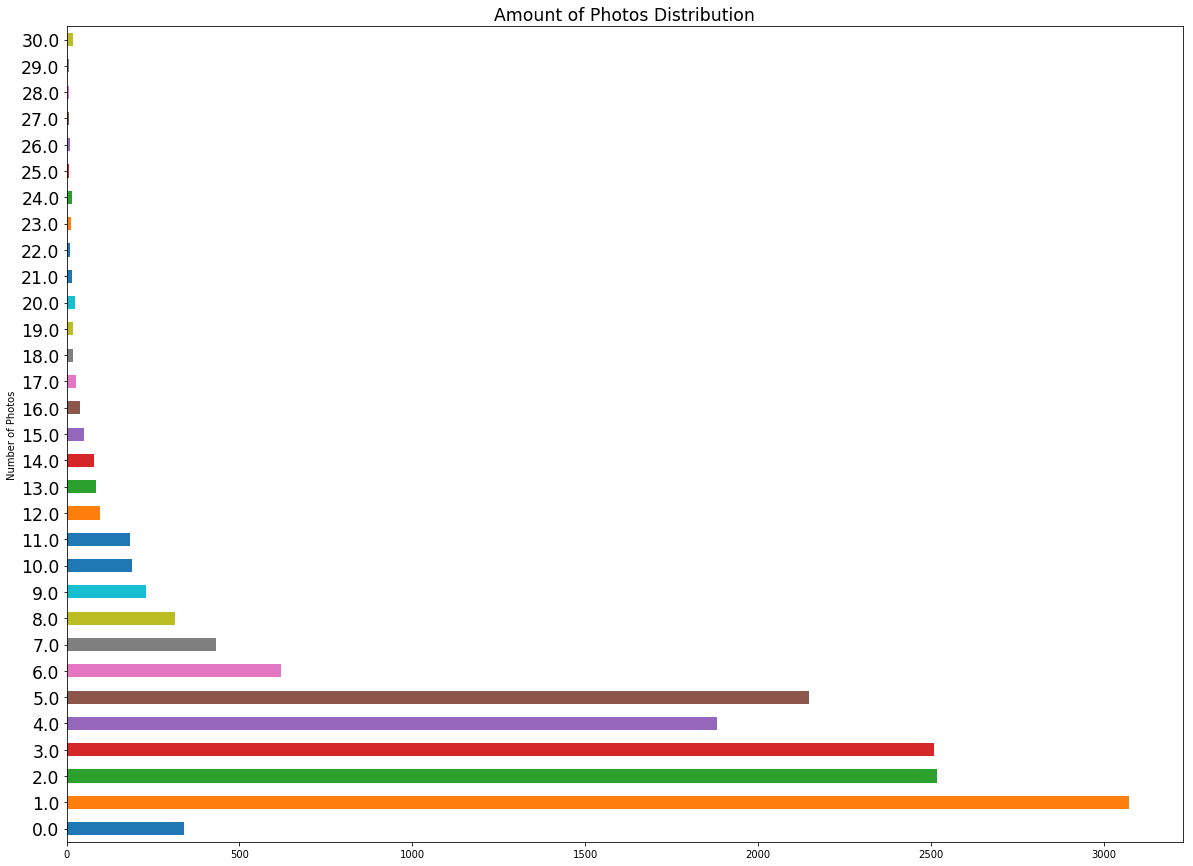

In [79]:
train['PhotoAmt'].value_counts().sort_index().plot(kind='barh',
                                                       figsize=(20,15))
plt.yticks(fontsize='xx-large')
plt.ylabel('Number of Photos')
plt.title('Amount of Photos Distribution', fontsize='xx-large')

<b>Most listings that have photos only have 1-5 of them.

## Add image metadata

<b>The image metadata is given by a collection of JSON files with the 'PetID' of the corresponding pet in the name of the file. Some pets have multiple pictures but I will initially just use the first three photos of each pet if available as these are likely the main photos seen by people searching for pets to adopt and thus have the largest effect on drawing in a perspective adoption.
  

In [92]:
for index, row in train.iterrows():  ## First photo
    file = 'train_metadata/' + row['PetID'] + '-1.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        train.loc[index, 'vertex_x']= vertex_x
        train.loc[index, 'vertex_y']= vertex_y
        train.loc[index, 'bounding_conf']= bounding_confidence
        train.loc[index, 'bounding_imp']= bounding_importance_frac
        train.loc[index, 'dom_blue']= dominant_blue
        train.loc[index, 'dom_green']= dominant_green
        train.loc[index, 'dom_red']= dominant_red
        train.loc[index, 'pixel_frac']= dominant_pixel_frac
        train.loc[index, 'score']= dominant_score
    else:
        train.loc[index, 'vertex_x']= -1
        train.loc[index, 'vertex_y']= -1
        train.loc[index, 'bounding_conf']= -1
        train.loc[index, 'bounding_imp']= -1
        train.loc[index, 'dom_blue']= -1
        train.loc[index, 'dom_green']= -1
        train.loc[index, 'dom_red']= -1
        train.loc[index, 'pixel_frac']= -1
        train.loc[index, 'score']= -1

In [96]:
for index, row in train.iterrows():  ## Second photo
    file = 'train_metadata/' + row['PetID'] + '-2.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        try:
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        except:
            dominant_blue = -1
        try:
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        except: 
            dominant_green = -1
        try: 
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        except:
            dominant_red = -1
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        train.loc[index, 'vertex_x2']= vertex_x
        train.loc[index, 'vertex_y2']= vertex_y
        train.loc[index, 'bounding_conf2']= bounding_confidence
        train.loc[index, 'bounding_imp2']= bounding_importance_frac
        train.loc[index, 'dom_blue2']= dominant_blue
        train.loc[index, 'dom_green2']= dominant_green
        train.loc[index, 'dom_red2']= dominant_red
        train.loc[index, 'pixel_frac2']= dominant_pixel_frac
        train.loc[index, 'score2']= dominant_score
    else:
        train.loc[index, 'vertex_x2']= -1
        train.loc[index, 'vertex_y2']= -1
        train.loc[index, 'bounding_conf2']= -1
        train.loc[index, 'bounding_imp2']= -1
        train.loc[index, 'dom_blue2']= -1
        train.loc[index, 'dom_green2']= -1
        train.loc[index, 'dom_red2']= -1
        train.loc[index, 'pixel_frac2']= -1
        train.loc[index, 'score2']= -1

In [97]:
for index, row in train.iterrows():  ## Third photo
    file = 'train_metadata/' + row['PetID'] + '-3.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        try:
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        except:
            dominant_blue = -1
        try:
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        except: 
            dominant_green = -1
        try: 
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        except:
            dominant_red = -1
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        train.loc[index, 'vertex_x3']= vertex_x
        train.loc[index, 'vertex_y3']= vertex_y
        train.loc[index, 'bounding_conf3']= bounding_confidence
        train.loc[index, 'bounding_imp3']= bounding_importance_frac
        train.loc[index, 'dom_blue3']= dominant_blue
        train.loc[index, 'dom_green3']= dominant_green
        train.loc[index, 'dom_red3']= dominant_red
        train.loc[index, 'pixel_frac3']= dominant_pixel_frac
        train.loc[index, 'score3']= dominant_score
    else:
        train.loc[index, 'vertex_x3']= -1
        train.loc[index, 'vertex_y3']= -1
        train.loc[index, 'bounding_conf3']= -1
        train.loc[index, 'bounding_imp3']= -1
        train.loc[index, 'dom_blue3']= -1
        train.loc[index, 'dom_green3']= -1
        train.loc[index, 'dom_red3']= -1
        train.loc[index, 'pixel_frac3']= -1
        train.loc[index, 'score3']= -1

In [98]:
for index, row in test.iterrows():  # First photo
    file = 'test_metadata/' + row['PetID'] + '-1.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        test.loc[index, 'vertex_x']= vertex_x
        test.loc[index, 'vertex_y']= vertex_y
        test.loc[index, 'bounding_conf']= bounding_confidence
        test.loc[index, 'bounding_imp']= bounding_importance_frac
        test.loc[index, 'dom_blue']= dominant_blue
        test.loc[index, 'dom_green']= dominant_green
        test.loc[index, 'dom_red']= dominant_red
        test.loc[index, 'pixel_frac']= dominant_pixel_frac
        test.loc[index, 'score']= dominant_score
    else:
        test.loc[index, 'vertex_x']= -1
        test.loc[index, 'vertex_y']= -1
        test.loc[index, 'bounding_conf']= -1
        test.loc[index, 'bounding_imp']= -1
        test.loc[index, 'dom_blue']= -1
        test.loc[index, 'dom_green']= -1
        test.loc[index, 'dom_red']= -1
        test.loc[index, 'pixel_frac']= -1
        test.loc[index, 'score']= -1

In [99]:
for index, row in test.iterrows(): # Second photo
    file = 'test_metadata/' + row['PetID'] + '-2.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        try:
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        except:
            dominant_blue = -1
        try:
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        except: 
            dominant_green = -1
        try: 
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        except:
            dominant_red = -1
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        test.loc[index, 'vertex_x2']= vertex_x
        test.loc[index, 'vertex_y2']= vertex_y
        test.loc[index, 'bounding_conf2']= bounding_confidence
        test.loc[index, 'bounding_imp2']= bounding_importance_frac
        test.loc[index, 'dom_blue2']= dominant_blue
        test.loc[index, 'dom_green2']= dominant_green
        test.loc[index, 'dom_red2']= dominant_red
        test.loc[index, 'pixel_frac2']= dominant_pixel_frac
        test.loc[index, 'score2']= dominant_score
    else:
        test.loc[index, 'vertex_x2']= -1
        test.loc[index, 'vertex_y2']= -1
        test.loc[index, 'bounding_conf2']= -1
        test.loc[index, 'bounding_imp2']= -1
        test.loc[index, 'dom_blue2']= -1
        test.loc[index, 'dom_green2']= -1
        test.loc[index, 'dom_red2']= -1
        test.loc[index, 'pixel_frac2']= -1
        test.loc[index, 'score2']= -1

In [100]:
for index, row in test.iterrows(): # Third photo
    file = 'test_metadata/' + row['PetID'] + '-3.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        try:
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        except:
            dominant_blue = -1
        try:
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        except: 
            dominant_green = -1
        try: 
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        except:
            dominant_red = -1
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        test.loc[index, 'vertex_x3']= vertex_x
        test.loc[index, 'vertex_y3']= vertex_y
        test.loc[index, 'bounding_conf3']= bounding_confidence
        test.loc[index, 'bounding_imp3']= bounding_importance_frac
        test.loc[index, 'dom_blue3']= dominant_blue
        test.loc[index, 'dom_green3']= dominant_green
        test.loc[index, 'dom_red3']= dominant_red
        test.loc[index, 'pixel_frac3']= dominant_pixel_frac
        test.loc[index, 'score3']= dominant_score
    else:
        test.loc[index, 'vertex_x3']= -1
        test.loc[index, 'vertex_y3']= -1
        test.loc[index, 'bounding_conf3']= -1
        test.loc[index, 'bounding_imp3']= -1
        test.loc[index, 'dom_blue3']= -1
        test.loc[index, 'dom_green3']= -1
        test.loc[index, 'dom_red3']= -1
        test.loc[index, 'pixel_frac3']= -1
        test.loc[index, 'score3']= -1

## Add sentiment data

<b> The sentiment data, similar to the image data, is provided as JSON files with the 'PetID' of the corresponding pet as the file name.
    The relevant values I chose to include from the sentiment data are magnitude and score.

In [101]:
for index, row in train.iterrows():
    file = 'train_sentiment/' + row['PetID'] + '.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        mag = data['documentSentiment']['magnitude']
        score = data['documentSentiment']['score']     
        train.loc[index, 'magnitude']= mag
        train.loc[index, 'sentiment_score']= score
    else:
        train.loc[index, 'magnitude']= -1
        train.loc[index, 'sentiment_score']= -1

In [102]:
for index, row in test.iterrows():
    file = 'test_sentiment/' + row['PetID'] + '.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        mag = data['documentSentiment']['magnitude']
        score = data['documentSentiment']['score']     
        test.loc[index, 'magnitude']= mag
        test.loc[index, 'sentiment_score']= score
    else:
        test.loc[index, 'magnitude']= -1
        test.loc[index, 'sentiment_score']= -1

## Save data before adding addtional columns

<b> I will be adding additional columns of data but wanted to save a copy of the train and test sets to compare with later on.

In [103]:
train.to_csv('pre_train.csv')
test.to_csv('pre_test.csv')

## Add name and description length

<b> To include a bit more data on 'Description' column and the otherwise unused 'Name' column, I decided to include the length of each as new columns of data. 

In [113]:
train['NameLength'] = train['Name'].map(lambda x: len(str(x))).astype('int')
train['DescLength'] = train['Description'].map(lambda x: len(str(x))).astype('int')
test['NameLength'] = test['Name'].map(lambda x: len(str(x))).astype('int')
test['DescLength'] = test['Description'].map(lambda x: len(str(x))).astype('int')

Text(0.5, 1.0, 'Average Description Length')

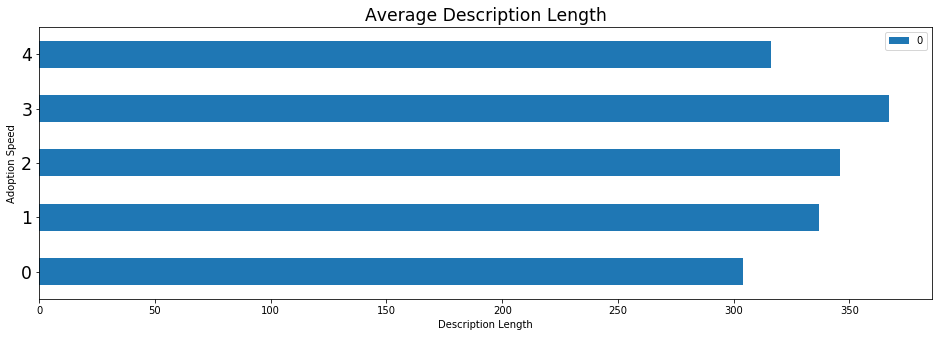

In [125]:
pd.DataFrame([train['DescLength'][train['AdoptionSpeed'] == 0].mean(),
              train['DescLength'][train['AdoptionSpeed'] == 1].mean(),
              train['DescLength'][train['AdoptionSpeed'] == 2].mean(),
              train['DescLength'][train['AdoptionSpeed'] == 3].mean(),
              train['DescLength'][train['AdoptionSpeed'] == 4].mean()]).plot(kind='barh',figsize=(16,5))
plt.yticks(fontsize='xx-large')
plt.ylabel('Adoption Speed')
plt.xlabel('Description Length')
plt.title('Average Description Length', fontsize='xx-large')

<b> There average description length trends upward as the adoption speed window increases until it hits level 4, where the average description length then is lower.

## Add dog data

<b> Using data from an AKC website as well as Wikipedia, I assigned a breed group to each dog breed as I suspect that there is a difference in adoptability amongst the dog breed groups. I added these breed groups in Microsoft Excel and generated a csv file 'dog_breeds' using the providing csv of breed labels. Now I just have to add a new column 'Group' to the train and test set. Since this only works for dogs, any cats will just be assigned the group 'Cat'.

In [126]:
dog_data = pd.read_csv('dog_breeds.csv')

In [127]:
dog_data.head()

,Unnamed: 0,BreedID,Type,BreedName,Group
0,0,1,1,Affenpinscher,Toy
1,1,2,1,Afghan Hound,Hound
2,2,3,1,Airedale Terrier,Terrier
3,3,4,1,Akbash,Working
4,4,5,1,Akita,Working


In [128]:
for index, row in train.iterrows():
    for i, r in dog_data.iterrows():
        if row['Breed1'] == r['BreedID']:
            train.at[index,'Group'] = r['Group']
            break

In [129]:
for index, row in test.iterrows():
    for i, r in dog_data.iterrows():
        if row['Breed1'] == r['BreedID']:
            test.at[index,'Group'] = r['Group']
            break

In [130]:
train.Group.isna().sum()

6853

In [131]:
dog_data.columns

Index(['Unnamed: 0', 'BreedID', 'Type', 'BreedName', 'Group'], dtype='object')

In [132]:
for index, row in train.iterrows():
    try:
        breed = row['Breed1']
        group = dog_data[dog_data['BreedID'] == breed]['Group'].values[0]
    except:
        group = 'Cat'
    train.loc[index,'Group'] = group    

In [133]:
for index, row in test.iterrows():
    try:
        breed = row['Breed1']
        group = dog_data[dog_data['BreedID'] == breed]['Group'].values[0]
    except:
        group = 'Cat'
    test.loc[index,'Group'] = group 

Text(0.5, 1.0, 'Distribution of Dog Groups')

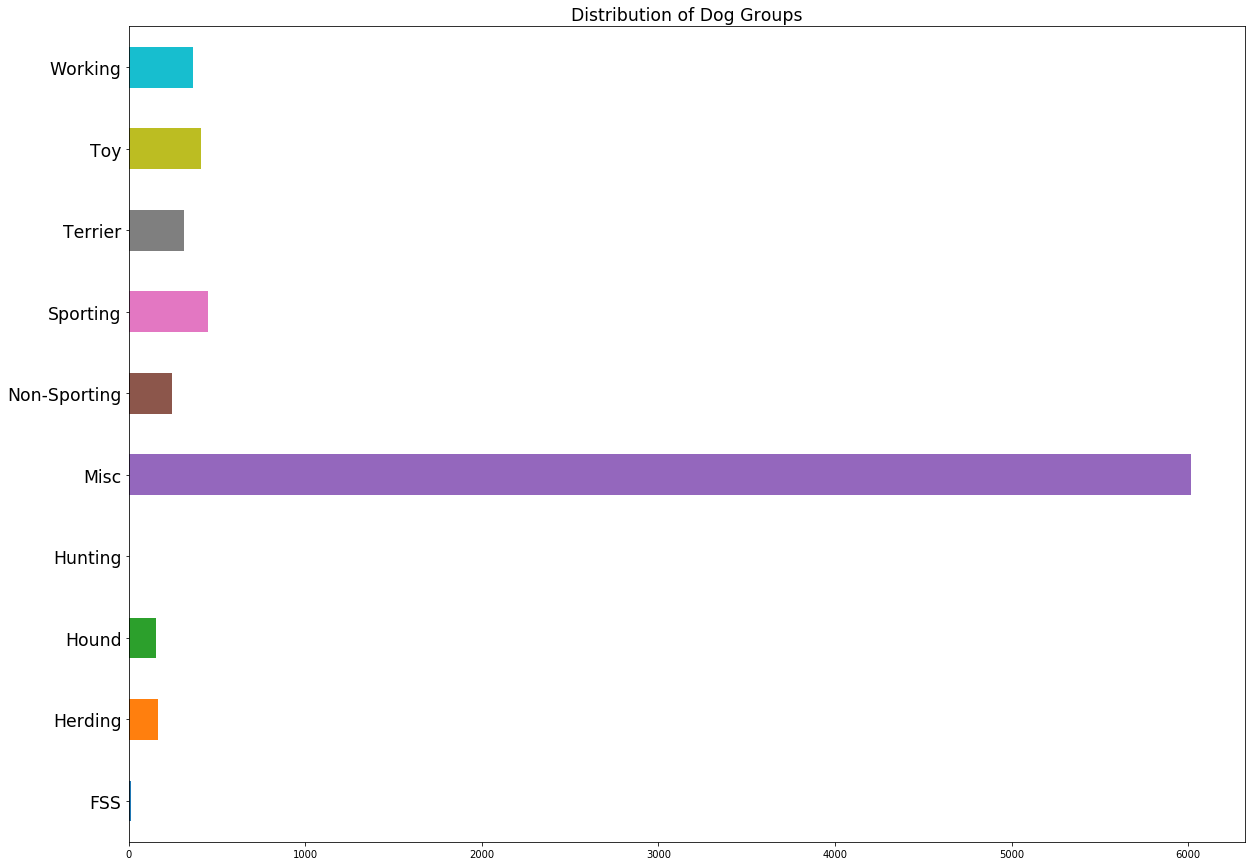

In [134]:
train['Group'][train['Group'] != 'Cat'].value_counts().sort_index().plot(kind='barh',
                                                       figsize=(20,15))
plt.yticks(fontsize='xx-large')
plt.title('Distribution of Dog Groups', fontsize='xx-large')

<b> It seems that 'Misc' is by far the most common group assigned to the dogs. 

Text(0.5, 1.0, 'Distribution of Dog Groups')

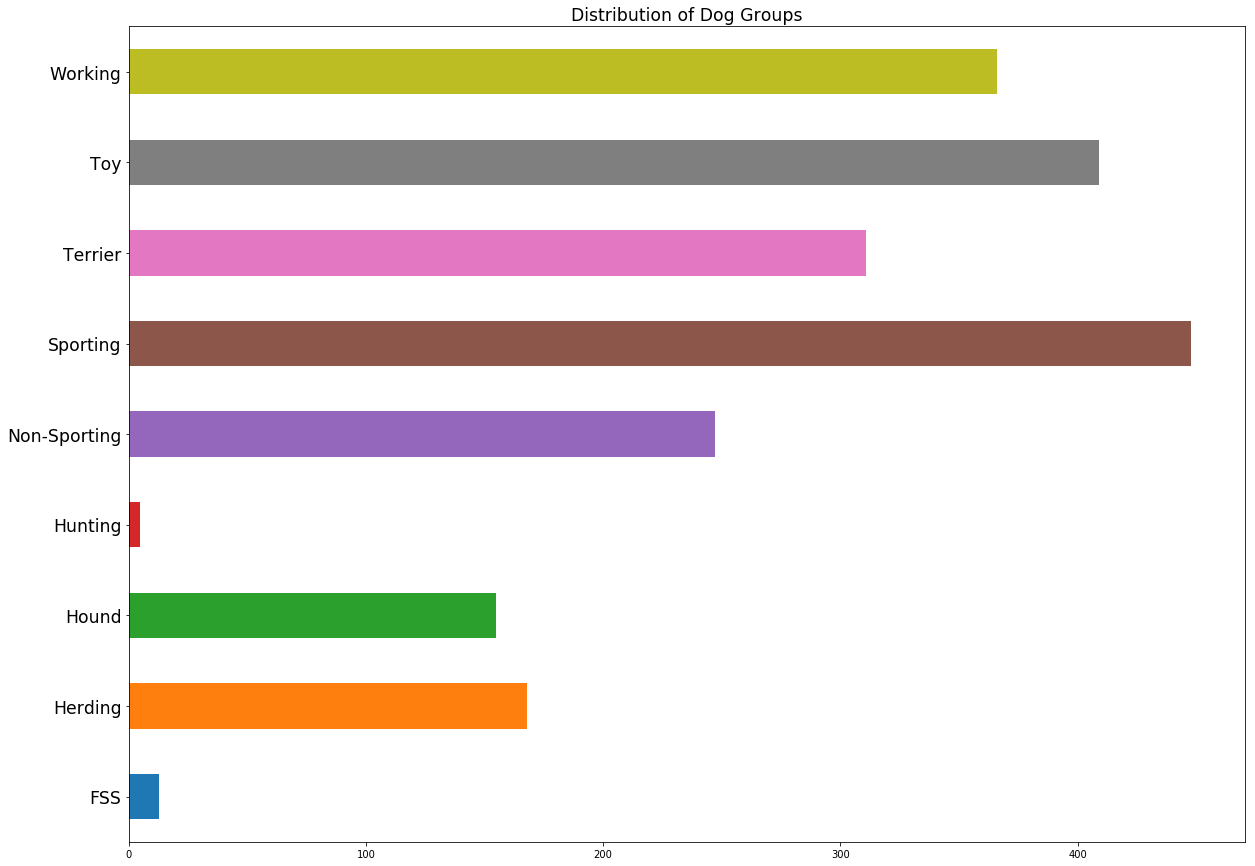

In [144]:
train['Group'][(train['Group'] != 'Cat') & (train['Group'] != 'Misc')].value_counts().sort_index().plot(kind='barh',
                                                       figsize=(20,15))
plt.yticks(fontsize='xx-large')
plt.title('Distribution of Dog Groups', fontsize='xx-large')

<b> Removing the 'Misc' group we can see the distribution of the other groups much better. From this, 'Sporting' and 'Toy' are the most common with 'Hunting' being the least common.

## Add cat data

<b> Using data from http://www.catbreedslist.com, I decided to include two new variables for the 'Cats' in the dataset. The first is 'Hypo' which is whether or not the cat breed is hypoallergenic. The second is 'Cute' which if the value in this column is 1 then that cat breed is one of the top 10 cutest cat breeds. 

In [135]:
cat_data = pd.read_csv('cat_info.csv')

In [136]:
cat_data.head()

,BreedID,Type,BreedName,Cute,Hypo
0,241,2,Abyssinian,0,0
1,242,2,American Curl,1,0
2,243,2,American Shorthair,1,0
3,244,2,American Wirehair,0,0
4,245,2,Applehead Siamese,0,0


In [137]:
for index, row in train.iterrows():
    try:
        breed = row['Breed1']
        cute = cat_data[cat_data['BreedID'] == breed]['Cute'].values[0]
        hypo = cat_data[cat_data['BreedID'] == breed]['Hypo'].values[0]
    except:
        cute = -1
        hypo = -1
    train.loc[index,'Cat_Cute'] = cute
    train.loc[index,'Cat_Hypo'] = hypo

In [138]:
for index, row in test.iterrows():
    try:
        breed = row['Breed1']
        cute = cat_data[cat_data['BreedID'] == breed]['Cute'].values[0]
        hypo = cat_data[cat_data['BreedID'] == breed]['Hypo'].values[0]
    except:
        cute = -1
        hypo = -1
    test.loc[index,'Cat_Cute'] = cute
    test.loc[index,'Cat_Hypo'] = hypo

Text(0.5, 1.0, 'Hypoallergenic Adoption Speeds')

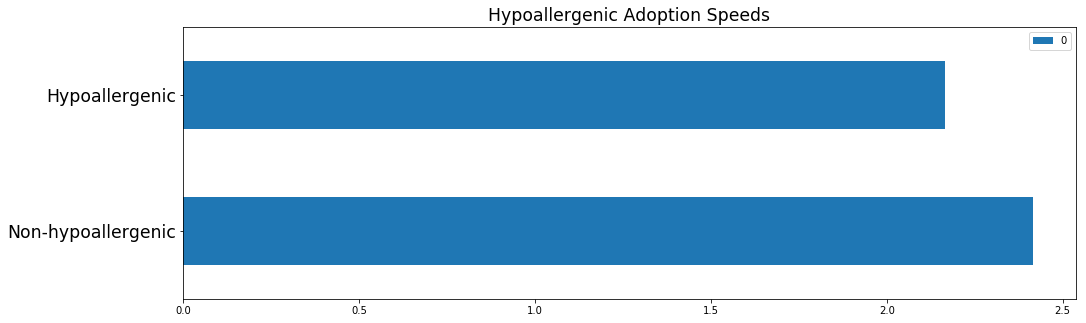

In [155]:
pd.DataFrame([train['AdoptionSpeed'][train['Cat_Hypo'] == 0].mean(),train['AdoptionSpeed'][train['Cat_Hypo'] == 1].mean()]).rename({1:'Hypoallergenic', 0:'Non-hypoallergenic'}).plot(kind='barh',figsize=(16,5))
plt.yticks(fontsize='xx-large')
plt.title('Hypoallergenic Adoption Speeds', fontsize='xx-large')

<b> It seems that hypoallergenic cat breeds are adopted more quickly on average than non-hypoallergenic cat breeds.

## Add state data

<b> Using census data found on Wikipedia for the states in Malaysia, I added the population, percentage of urban environment, and population density for each state.
 

In [150]:
state_data = pd.read_csv('state_data.csv')
state_data.head()

,State,Population,StateID,UrbanPercent,PopDensity
0,Kuala Lumpur,1627172,41401,100.0,6891
1,Labuan,86908,41415,82.3,950
2,Johor,3348283,41336,71.9,174
3,Kedah,1890098,41325,64.6,199
4,Kelantan,1459994,41367,42.4,97


In [151]:
for index, row in train.iterrows():
    state = row['State']
    urban = state_data[state_data['StateID'] == state]['UrbanPercent'].values[0]
    pop = state_data[state_data['StateID'] == state]['Population'].values[0]
    pop_den = state_data[state_data['StateID'] == state]['PopDensity'].values[0]

    train.loc[index,'UrbanPercent'] = urban
    train.loc[index,'Population'] = pop
    train.loc[index,'PopDensity'] = pop_den

In [152]:
for index, row in test.iterrows():
    state = row['State']
    urban = state_data[state_data['StateID'] == state]['UrbanPercent'].values[0]
    pop = state_data[state_data['StateID'] == state]['Population'].values[0]
    pop_den = state_data[state_data['StateID'] == state]['PopDensity'].values[0]

    test.loc[index,'UrbanPercent'] = urban
    test.loc[index,'Population'] = pop
    test.loc[index,'PopDensity'] = pop_den

## Save preprocessed data

In [170]:
train.to_csv('processed_train.csv')
test.to_csv('processed_test.csv')

## Import preprocessed data

In [171]:
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')

## Encode categorical variables

In [172]:
train = pd.get_dummies(train, columns = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
                                 'State', 'Type', 'Group'
                                ])
test = pd.get_dummies(test, columns = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
                                 'State', 'Type', 'Group'
                                ])

## Make sure train and test have same columns

In [173]:
diff_columns = set(train.columns).difference(set(test.columns))
for i in diff_columns:
    test[i] = test.apply(lambda _: 0, axis=1)
diff_columns2 = set(test.columns).difference(set(train.columns))
for i in diff_columns2:
    train[i] = train.apply(lambda _: 0, axis=1)
test = test[train.columns]

In [174]:
train.shape

(14993, 453)

In [175]:
test.shape

(3948, 453)

## Set target variable

In [176]:
target = train['AdoptionSpeed'].astype('int')

## Drop irrelevent columns

In [177]:
X = train.drop(['Name', 'RescuerID', 'Description', 'PetID', 'AdoptionSpeed', 'Unnamed: 0'], axis=1)
X_pred = test.drop(['Name', 'RescuerID', 'Description', 'Unnamed: 0'], axis=1)

## Test metric

According to the rules for the Kaggle competition, the results are scored using the quadratic weighted kappa. I will be using the cohen_kappa_score with 'weights' set to quadratic from sklearn.metrics to evaluate my results.

## Set aside validation set

In [183]:
X_train, X_val, target_train, target_val = train_test_split(X, 
                                                      target, 
                                                      test_size=0.18, 
                                                      random_state=47)

## Baseline RandomForest

In [185]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, target_train)

C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [186]:
cohen_kappa_score(target_val, clf_rf.predict(X_val), weights='quadratic')

0.23415329628513704

<b> Running a baseline RandomForest classifier gives a fairly low score which I will now try to improve.

## Baseline XGBoost

In [190]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, target_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [192]:
cohen_kappa_score(target_val, clf_xgb.predict(X_val), weights='quadratic')

0.37136652559777095

<b> Using an XGBClassifier improved the cohen score significantly.

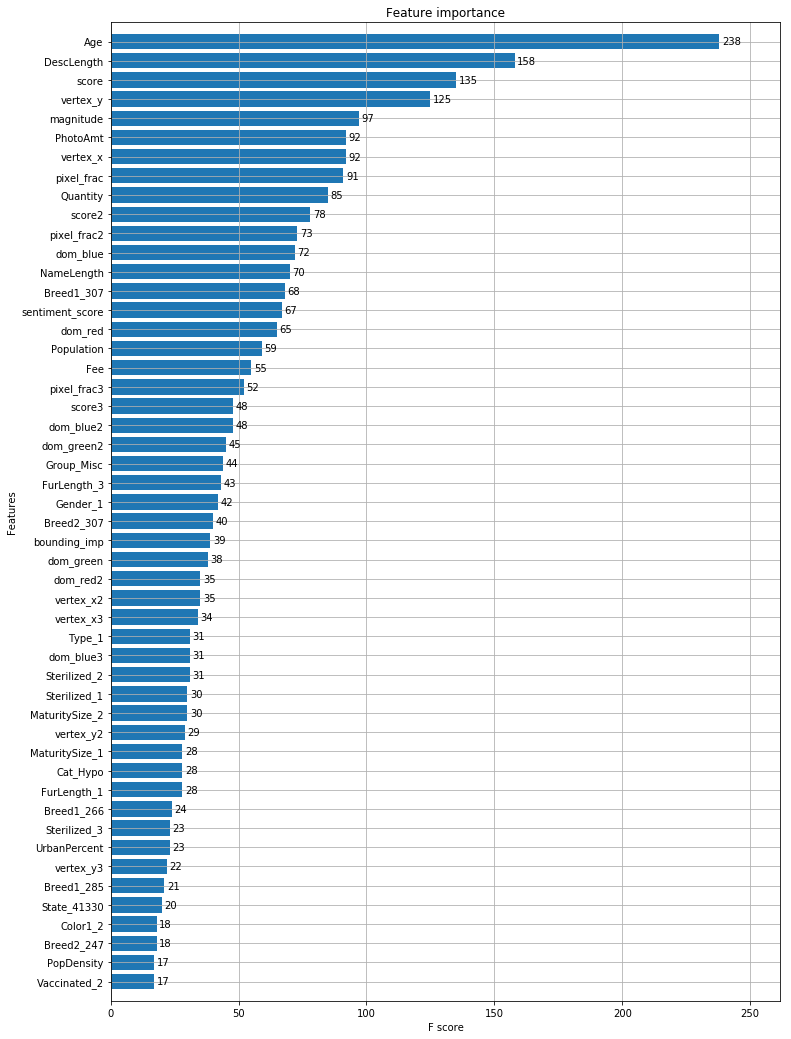

In [194]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(clf_xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

<b> From the feature importance chart it seems that 'Age', 'DescLength', and 'score' are the top 3 most important features.

## Parameter tuning

### RandomForest Tuning

In [197]:
rf_params = {
    'bootstrap': [True, False],
    'max_depth': [25, 50, 75, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [20, 50, 65],
    'min_samples_split': [5, 10, 15],
    'n_jobs':[-1],
    'n_estimators': [50, 100, 200, 300],
    'random_state' : [47]
}

In [203]:
rf_gridsearch = GridSearchCV(estimator = clf_rf, 
                                      param_grid = rf_params, 
                                      cv = 3, 
                                      n_jobs = -1, 
                                      verbose = 1, 
                                      scoring=make_scorer(cohen_kappa_score,weights='quadratic'))

In [204]:
rf_gridsearch.fit(X, target)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'n_estimators': [50, 100, 200, 300], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [20, 50, 65], 'max_depth': [25, 50, 75, 100], 'random_state': [47], 'n_jobs': [-1], 'max_features': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(cohen_kappa_score, weights=quadratic),
       verbose=1)

In [205]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 5,
 'n_estimators': 300,
 'n_jobs': -1,
 'random_state': 47}

In [206]:
rf_gridsearch.best_score_

0.32221078336788467

### XGBoost Tuning

In [215]:
xgb_params = {'objective' : ['multi:softmax'],
              'eta' : [0.01],
              'max_depth' : [3, 4, 6],
              'min_child_weight' : [4, 6, 8],
}

In [216]:
xgb_gridsearch = GridSearchCV(estimator = clf_xgb, 
                                      param_grid = xgb_params, 
                                      cv = 3, 
                                      n_jobs = -1, 
                                      verbose = 1, 
                                      scoring=make_scorer(cohen_kappa_score,weights='quadratic'))

In [217]:
xgb_gridsearch.fit(X, target)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  7.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 6], 'min_child_weight': [4, 6, 8], 'objective': ['multi:softmax'], 'eta': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(cohen_kappa_score, weights=quadratic),
       verbose=1)

In [220]:
xgb_gridsearch.best_params_

{'eta': 0.01,
 'max_depth': 4,
 'min_child_weight': 8,
 'objective': 'multi:softmax'}

In [221]:
xgb_gridsearch.best_score_

0.35513511519720714

In [245]:
test_pred = clf.predict(X_pred.drop(['AdoptionSpeed','PetID'], axis=1))

In [58]:
pred = pd.DataFrame()
pred['PetID'] = X_pred['PetID']
pred['AdoptionSpeed'] = test_pred
pred.set_index('PetID').to_csv("submission.csv", index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000227BFF72668>]],
      dtype=object)

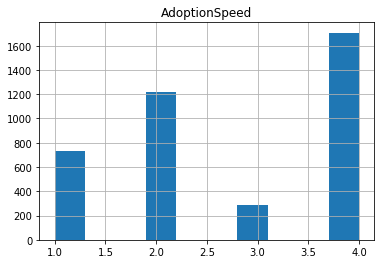

In [62]:
pred.hist()

### This received a score of 0.337 on the Kaggle competition's test data #1

## Standardization

In [143]:
X_stan = StandardScaler().fit_transform(X)

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [144]:
test_stan = StandardScaler().fit_transform(X_pred.drop(['AdoptionSpeed','PetID'], axis=1))

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Dimensionality reduction

In [145]:
pca = PCA(n_components=0.8, svd_solver='full', random_state=47)
principalComponents = pca.fit_transform(X_stan)

In [146]:
test_pca = pca.transform(test_stan)

## Random Forest Baseline

In [255]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_stan, target)

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [256]:
scores = cross_val_score(clf, X_stan, target, cv=3)
scores.mean()

0.40618927365512003

In [257]:
quadratic_weighted_kappa(target, clf_rf.predict(X_stan))

0.9859424501243039

In [258]:
test_pred = clf_rf.predict(test_stan)

In [259]:
pred = pd.DataFrame()
pred['PetID'] = X_pred['PetID']
pred['AdoptionSpeed'] = test_pred
pred.set_index('PetID').to_csv("submission-rf.csv", index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002279140C6A0>]],
      dtype=object)

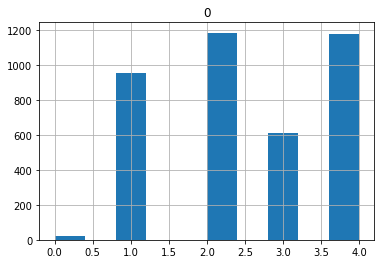

In [260]:
pd.DataFrame(test_pred).hist()

### This received a score of 0.242 on the Kaggle competition's test data #1

In [261]:
import lightgbm as lgb

d_train = lgb.Dataset(X_stan, label=target)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['num_class'] = 5
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

clf = lgb.train(params, d_train, 100)

In [262]:
preds = clf.predict(X_stan, num_iteration=clf.best_iteration)
preds_round = np.array([])
for i in preds:
    k = 0
    c = 0
    for j in i:
        if j > k:
            k = j
            c += 1
    preds_round = np.append(preds_round, c)

In [263]:
pd.DataFrame(preds)

,0,1,2,3,4
0,0.028672,0.212389,0.276491,0.213621,0.268827
1,0.028561,0.220633,0.261740,0.207142,0.281924
2,0.025203,0.204471,0.278694,0.236541,0.255091
3,0.025198,0.194609,0.262512,0.230506,0.287174
4,0.025186,0.208209,0.286982,0.216172,0.263451
5,0.027978,0.208111,0.282343,0.213277,0.268291
6,0.031063,0.212125,0.260599,0.207632,0.288580
7,0.025613,0.202703,0.283709,0.223803,0.264172
8,0.027830,0.226639,0.278091,0.214860,0.252580
9,0.028027,0.202143,0.262813,0.207768,0.299249


In [210]:
pd.DataFrame(preds_round).head()

,0
0,3.0
1,4.0
2,3.0
3,4.0
4,3.0


In [192]:
target.values.shape

(14993,)

In [196]:
preds_round.shape

(14993,)

In [211]:
accuracy_score(preds_round, target.values)

0.32335089708530645

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000227D6E9CE10>]],
      dtype=object)

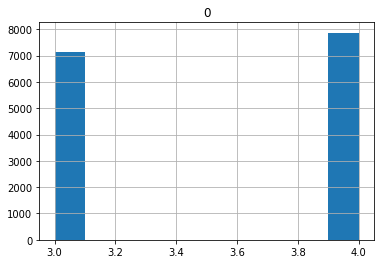

In [212]:
pd.DataFrame(preds_round).hist()